# BERT Fine Tuning Notebook for Cola 

In [2]:
import torch
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1070


# Importing Cola using pandas

In [75]:

# Path for cola
data_path = "/home/garysnake/Desktop/structural-probes/experiments/data/cola_public"
data_train_path = data_path+"/raw/tsv/in_domain_train.tsv"

import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv(data_train_path, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
2389,l-93,1,NaN,Angela characterized Shelly as a lifesaver.
5048,ks08,1,NaN,They're not finding it a stress being in the s...
3133,l-93,0,*,Paul exhaled on Mary.
5955,c_13,0,*,I ordered if John drink his beer.
625,bc01,1,NaN,Press the stamp against the pad completely.
3542,ks08,0,*,They can very.
6915,m_02,1,NaN,This arch is supporting the weight of the tower.
2908,l-93,1,NaN,That new handle detaches easily.
5857,c_13,1,NaN,The Brazilians pumped the oil across the river.
4191,ks08,1,NaN,It is a wooden desk.


In [80]:
data_path = "/home/garysnake/Desktop/structural-probes/experiments/data/cola_public"
data_train_path = data_path+"/raw/tsv/in_domain_train.tsv"

In [81]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values



from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') #To make it consistent with tokenizer
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading BERT tokenizer...
 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['Our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [3458, 2053, 1281, 112, 189, 4417, 1142, 3622, 117, 1519, 2041, 1103, 1397, 1141, 1195, 17794, 119]


#### Splitting input into label 1 and 0(Optional)

In [82]:
# =========================== Splitting for 
# Section used for divide cola into corrected syntax part and erroranous syntax part

df.loc[0]
df.label
pos_label_train = [df.sentence[i] for i,label in enumerate(df.label) if label == 1]
zero_label_train = [df.sentence[i] for i,label in enumerate(df.label) if label == 0]

# Tokenize Training sentence + Split

In [83]:
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)


In [5]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [84]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


# Training Using BertForSequenceClassification

Create iterator save on memory, relax on loading the entire dataset into the memory

In [231]:
# Tuning Parameters
batch_size = 50
lr = 2e-5
eps = 1e-8
epochs = 4


args = {
    "batch_size": batch_size,
    "lr": lr,
    "eps": eps,
    "epochs": 4
}



In [232]:

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [233]:
# =================== Sequence Classification Model =======================

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


# =================== Optimizer =======================


# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )


# =================== Schedluer =======================


from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training Loop

In [229]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Actual Loop

In [234]:
    
    
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch_i, batch in enumerate(validation_dataloader):
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:18.
  Batch    80  of    154.    Elapsed: 0:00:36.
  Batch   120  of    154.    Elapsed: 0:00:53.

  Average training loss: 0.61
  Training epcoh took: 0:01:08

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.62
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:18.
  Batch    80  of    154.    Elapsed: 0:00:36.
  Batch   120  of    154.    Elapsed: 0:00:53.

  Average training loss: 0.60
  Training epcoh took: 0:01:08

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.61
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:18.
  Batch    80  of    154.    Elapsed: 0:00:35.
  Batch   120  of    154.    Elapsed: 0:00:53.

  Average training loss: 0.58
  Training epcoh took: 0:01:08

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.61
  Validation too

# Save Model code(optional)

In [21]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/home/garysnake/Desktop/structural-probes/experiments/results/bert_cola/save_model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /home/garysnake/Desktop/structural-probes/experiments/results/bert_cola/save_model


# Validation 

## This is the summary of the training

In [235]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.61,0.62,0.69,0:01:08,0:00:02
2,0.60,0.61,0.69,0:01:08,0:00:02
3,0.58,0.61,0.68,0:01:08,0:00:03
4,0.54,0.62,0.70,0:01:12,0:00:02


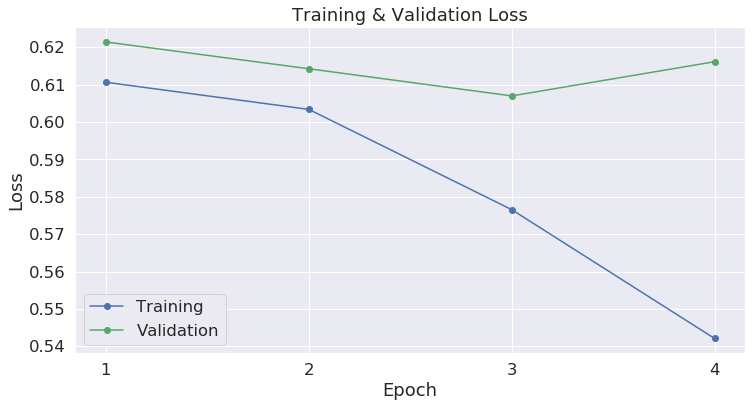

In [236]:
import matplotlib.pyplot as plt 
#  matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Test Set


In [237]:
tsv_name = "in_domain_train.tsv"
probe_name = "bert_base_distance_cola_50/train"

### Test Set Loading Data

In [238]:
import pandas as pd

# Load the dataset into a pandas dataframe.
temp_root_path = "/home/garysnake/Desktop/structural-probes/experiments/data/cola_public"
temp_data_path = temp_root_path+"/raw/tsv/"+tsv_name
df = pd.read_csv(temp_data_path, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
# batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 8,551



#### (Ignore this for now)This is used for splitting labels into correct and non correct prediciton

In [ ]:
def split_predicted_labels(preds, labels, index_start):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    pred_label = np.logical_xor(pred_flat, labels_flat)
    correct = []
    wrong = []
    for i,is_wrong in enumerate(pred_label):
        if is_wrong:
            wrong.append(i+index_start)
        else:
            correct.append(i+index_start)
    return correct, wrong

correct_id = []
wrong_id = []


# Calculate the accuracy for this batch of test sentences, and
# accumulate it over all batches.
# Splitting the correctly and wrongly predicted output          
#         batch_correct_id, batch_wrong_id = split_predicted_labels(logits, label_ids, batch_i*batch_size)
#         correct_id += batch_correct_id
#         wrong_id += batch_wrong_id


## Evaluate on Test Set

In [239]:
from sklearn.metrics import matthews_corrcoef, f1_score

# Prediction on test set


print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
# predictions , true_labels = [], []
batch_accuracy = []
mcc = []
f1 = []


# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Record batch accuracy
    batch_accuracy.append(flat_accuracy(logits, label_ids))

    # Record batch mcc  
    predict = np.argmax(logits, axis=1).flatten()
    mcc.append(matthews_corrcoef(label_ids, predict))
    f1.append(f1_score(label_ids, predict))
      
    # Store predictions and true labels
#     predictions.append(logits)
#     true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 8,551 test sentences...


/home/garysnake/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


    DONE.


### To plot UUAS vs Accuracy, batch size from micheal_experiment.py + following block need to be the same

# Plot UUAS vs Accuracy

171
171


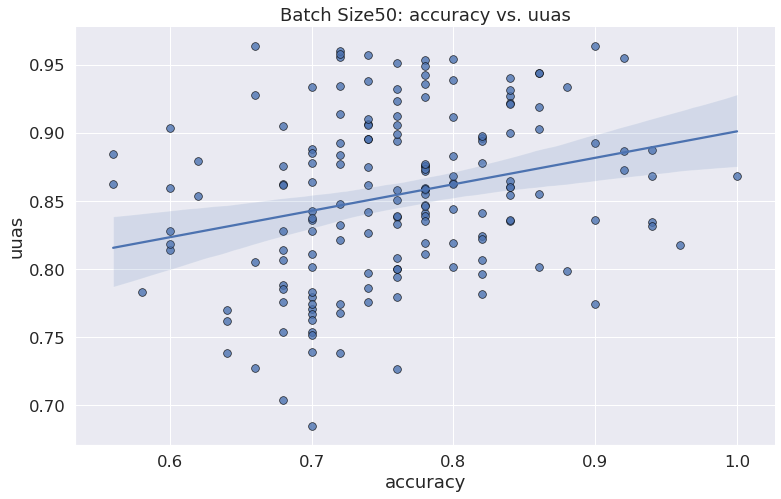

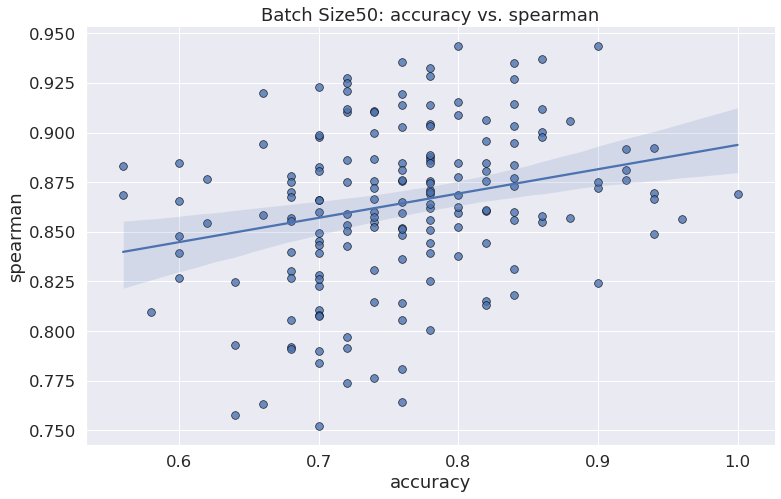

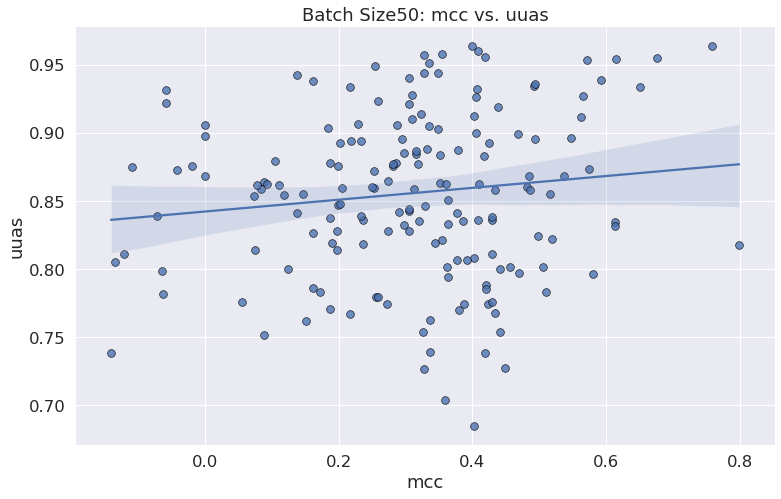

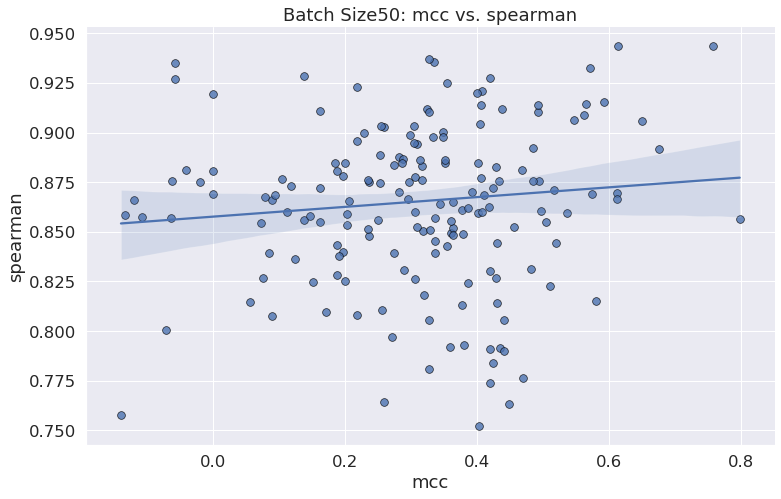

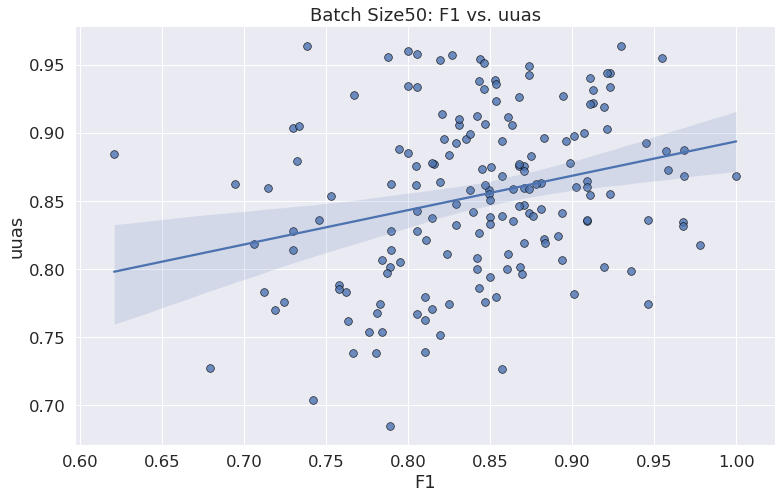

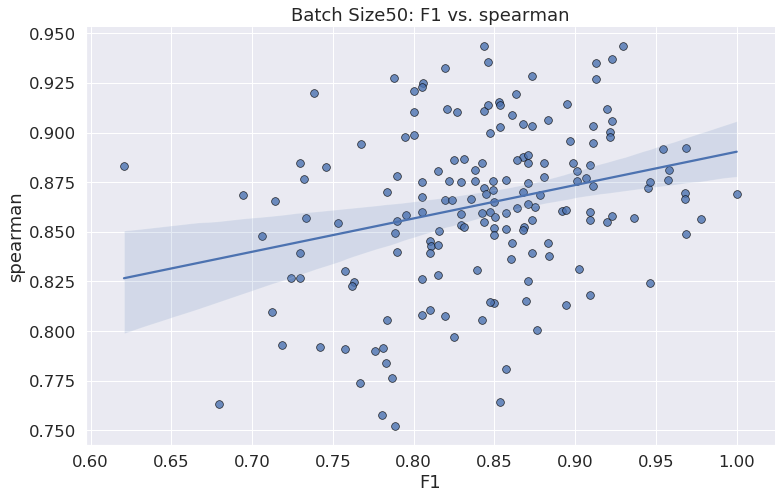

In [246]:
import matplotlib.pyplot as plt 
#  matplotlib inline

import seaborn as sns

def plot_scatter(x, y, x_name, y_name):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    
    df = pd.DataFrame(data={x_name:x, y_name:y})

    # Plot the learning curve.
#     plt.scatter(x, y)
    
    # Plot the regression line
    gridobj = sns.lmplot(x=x_name, y=y_name, data=df,
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

    # Label the plot.
    plt.title("Batch Size{:}: {:} vs. {:}".format(batch_size, x_name, y_name))
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()


    
#  Next step export this set, and run probe on this dev
# Next step might be running 

batch_uuas = []
with open('/home/garysnake/Desktop/structural-probes/experiments/results/'+probe_name+'.uuas','r') as f:
    for line in f.readlines():
        try:
            batch_uuas.append(float(line))
        except ValueError:
            pass


batch_spearman = []
with open('/home/garysnake/Desktop/structural-probes/experiments/results/'+probe_name+'.spearmanr_batch_average','r') as f:
    for line in f.readlines():
        try:
            batch_spearman.append(float(line))
        except ValueError:
            pass
        

print(len(batch_accuracy))
print(len(batch_uuas))  

batch_accuracy = batch_accuracy[:171]
mcc = mcc[:171]
f1 = f1[:171]
    

plot_scatter(batch_accuracy, batch_uuas, "accuracy", "uuas")

plot_scatter(batch_accuracy, batch_spearman, "accuracy", "spearman")

plot_scatter(mcc, batch_uuas, "mcc", "uuas")

plot_scatter(mcc, batch_spearman, "mcc", "spearman")

plot_scatter(f1, batch_uuas, "F1", "uuas")

plot_scatter(f1, batch_spearman, "F1", "spearman")



        

    


In [247]:
from scipy import stats

x_axis = [batch_uuas, batch_spearman]
y_axis = [batch_accuracy, f1, mcc]



pval_stats = []
coef_stats = []
for x in x_axis:
    col_pval_stats = []
    col_coef_stats = []
    for y in y_axis:
        pearson = stats.pearsonr(x,y)
        col_coef_stats.append(pearson[0])
        col_pval_stats.append(pearson[1]*100)
    pval_stats.append(col_pval_stats)
    coef_stats.append(col_coef_stats)


df_pval = pd.DataFrame(np.array(pval_stats), index=['uuas','spearman'], columns=["Accuracy","F1", "MCC"])
df_pval


,Accuracy,F1,MCC
uuas,0.04,3.70e-02,12.64
spearman,0.02,6.96e-03,26.92


In [248]:
df_coeff = pd.DataFrame(np.array(coef_stats), index=['uuas','spearman'], columns=["Accuracy","F1", "MCC"])
df_coeff

,Accuracy,F1,MCC
uuas,0.27,0.27,0.12
spearman,0.29,0.30,0.08
